### Project 2: Cocktail Recommendations

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

For this project, I'll be using a dummy dataset about cocktails featuring two tables:

- One contains 50 rows, each representing a bar patron, and 25 columns, each representing a cocktail offered by the bar. The cell values indicate a score the patron has provided for the given cocktail they've tried. If the value is null, they patron has not tried (or at least not rated) the cocktail.
- The second contains a row for each of the 25 columns, and 20 columns, where each column is a "feature," or quality of that cocktail (including types of liquor it includes, flavor and texture profiles).

Let's assume that at this high-tech bar, patrons order drinks through an app, which also prompts them to rate cocktails they've ordered. The bar has hired me to build a system for recommending cocktails to patrons based on their provided rankings. I have offered to build two different systems. One will be a **content-based** recommender that will suggest cocktails patrons haven't tried based on those cocktails' similarity to others they've expressed a preference for. The other will be a **collaborative filtering** system that will recommend cocktails to patrons based the preferences of *other* patrons with whom they appear to have similar tastes.

#### Data Set up

In [189]:
#import data
xl = pd.ExcelFile('../data/cocktail_toy_dataset.xlsx')

In [190]:
#list sheets
xl.sheet_names

['patrons_cocktails', 'cocktail_features']

In [191]:
#patrons by cocktail
df_pxc = xl.parse('patrons_cocktails', index_col='user_id')

In [192]:
#cocktail with features/details
df_c = xl.parse('cocktail_features', index_col='cocktail')

In [195]:
#preview patrons by cocktails data
print(df_pxc.shape)
df_pxc.head()

(51, 25)


,Mojito,Margarita,Manhattan,Cosmopolitan,Martini,Pina_Colada,Old_Fashioned,Mai_Tai,Negroni,Daiquiri,...,Caipirinha,Sazerac,Bloody_Mary,Sidecar,French_75,Bellini,Dark_N_Stormy,Tom_Collins,Ramos_Fizz,Vesper
user_id,,,,,,,,,,,,,,,,,,,,,
Aaliyah,5.0,4.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,5.0,...,5.0,NaN,NaN,NaN,NaN,5.0,4.0,4.0,NaN,NaN
Björn,2.0,3.0,5.0,NaN,5.0,NaN,5.0,NaN,4.0,2.0,...,NaN,5.0,3.0,4.0,3.0,NaN,NaN,3.0,NaN,5.0
Chen_Wei,4.0,5.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,4.0,...,4.0,NaN,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN
Dmitri,NaN,2.0,4.0,NaN,5.0,NaN,5.0,2.0,5.0,NaN,...,NaN,5.0,3.0,5.0,4.0,NaN,3.0,NaN,NaN,5.0
Esperanza,5.0,5.0,NaN,4.0,NaN,5.0,NaN,5.0,NaN,5.0,...,5.0,NaN,NaN,NaN,NaN,5.0,4.0,4.0,5.0,NaN


In [196]:
#preview cocktail features data
print(df_c.shape)
df_c.head()

(25, 20)


,rum,tequila,whiskey,vodka,gin,champagne,wine,sweet,sour,bitter,fruity,creamy,citrus,mint,strong,refreshing,herbal,spicy,savory,sparkling
cocktail,,,,,,,,,,,,,,,,,,,,
Mojito,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0
Margarita,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0
Manhattan,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
Cosmopolitan,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0
Martini,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0


#### Content-Based Filtering

Content-based filtering requires us to understand how similar cocktails are in order to recommend them to people who enjoy those similar cocktails. Therefore, our first step is to build a **similarity matrix** for each cocktail, based on the **cosine similarity** of each cocktail to every other one. Cosine similarity treats each cocktail's features as a vector, and provides a value based on the size of the angle between two vectors. Smaller angles between vectors mean greater similarity, which the cosine similarity function normalizes to a value between 0 and 1. 0 means two cocktails are completely dissimilar, while 1 would mean they are exactly the same.

In [197]:
#build cocktail similarity matrix as a dataframe
df_cocktail_sim = pd.DataFrame(
    cosine_similarity(df_c),
    index=df_c.index,
    columns=df_c.index
)

<Axes: xlabel='cocktail', ylabel='cocktail'>

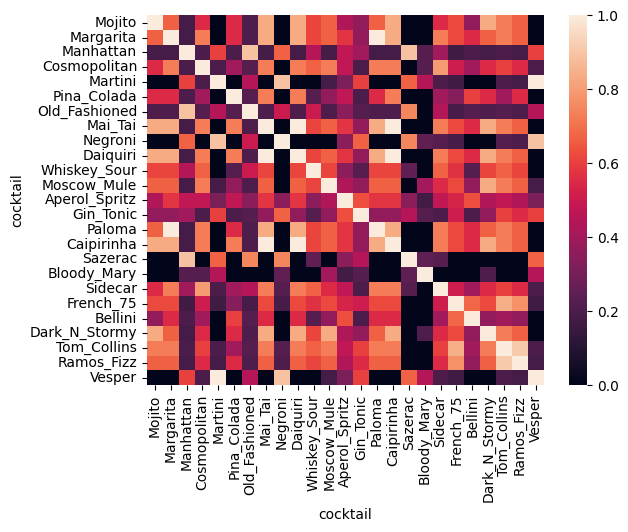

In [199]:
#present heatmap
sns.heatmap(df_cocktail_sim)

The above presents the similarity matrix as a heatmap, allowing us to get a quick visual sense of cocktail similarity. From this, we can see that, for example, a Margarita is incredibly similar to a Paloma, both of which are very dissimilar to a Negroni.

Now that we know how similar cocktails are to one another, we can take one patron as an example and try to recommend them some cocktails. Let's pick one person at random:

In [201]:
df_pxc.sample(1, random_state=905).index

Index(['Uche'], dtype='object', name='user_id')

Having landed on Uche, let's take a look at his cocktail ratings:

In [202]:
uche_ratings = df_pxc.loc['Uche']

In [203]:
uche_ratings

Mojito           NaN
Margarita        2.0
Manhattan        5.0
Cosmopolitan     NaN
Martini          5.0
Pina_Colada      NaN
Old_Fashioned    5.0
Mai_Tai          2.0
Negroni          5.0
Daiquiri         NaN
Whiskey_Sour     5.0
Moscow_Mule      2.0
Aperol_Spritz    NaN
Gin_Tonic        5.0
Paloma           2.0
Caipirinha       NaN
Sazerac          5.0
Bloody_Mary      4.0
Sidecar          5.0
French_75        4.0
Bellini          NaN
Dark_N_Stormy    NaN
Tom_Collins      2.0
Ramos_Fizz       NaN
Vesper           5.0
Name: Uche, dtype: float64

In order to recommend for Uche properly, we'll want to develop scores for cocktails he **hasn't rated** based on the cocktails he **has rated**. Therefore, we want a filtered dataframe that can account for the similarity across both of those sets.

In [206]:
#limit the columns to what he HAS rated (for calculating similarity)
#and rows to what he HASN'T rated (because we already know what he's rated and don't need to recommend them)
df_cocktail_sim_uche = df_cocktail_sim.loc[uche_ratings.isnull(), uche_ratings.notnull()]

In [207]:
df_cocktail_sim_uche

cocktail,Margarita,Manhattan,Martini,Old_Fashioned,Mai_Tai,Negroni,Whiskey_Sour,Moscow_Mule,Gin_Tonic,Paloma,Sazerac,Bloody_Mary,Sidecar,French_75,Tom_Collins,Vesper
cocktail,,,,,,,,,,,,,,,,
Mojito,0.666667,0.182574,0.000000,0.204124,0.833333,0.000000,0.612372,0.666667,0.365148,0.666667,0.000000,0.000000,0.547723,0.617213,0.730297,0.000000
Cosmopolitan,0.730297,0.200000,0.200000,0.223607,0.730297,0.000000,0.670820,0.730297,0.200000,0.730297,0.000000,0.223607,0.800000,0.507093,0.600000,0.200000
Pina_Colada,0.547723,0.200000,0.000000,0.223607,0.730297,0.000000,0.223607,0.365148,0.200000,0.547723,0.000000,0.000000,0.400000,0.338062,0.400000,0.000000
Daiquiri,0.833333,0.182574,0.000000,0.204124,1.000000,0.000000,0.612372,0.666667,0.365148,0.833333,0.000000,0.000000,0.730297,0.617213,0.730297,0.000000
Aperol_Spritz,0.577350,0.474342,0.316228,0.353553,0.577350,0.353553,0.353553,0.433013,0.632456,0.577350,0.353553,0.176777,0.474342,0.534522,0.474342,0.316228
Caipirinha,0.833333,0.182574,0.000000,0.204124,1.000000,0.000000,0.612372,0.666667,0.365148,0.833333,0.000000,0.000000,0.730297,0.617213,0.730297,0.000000
Bellini,0.547723,0.200000,0.000000,0.223607,0.547723,0.000000,0.223607,0.365148,0.200000,0.547723,0.000000,0.000000,0.400000,0.676123,0.400000,0.000000
Dark_N_Stormy,0.666667,0.182574,0.000000,0.204124,0.833333,0.000000,0.612372,0.833333,0.365148,0.666667,0.000000,0.204124,0.547723,0.617213,0.730297,0.000000
Ramos_Fizz,0.666667,0.182574,0.182574,0.204124,0.666667,0.204124,0.612372,0.666667,0.547723,0.666667,0.000000,0.000000,0.547723,0.771517,0.912871,0.182574


This dataframe represents the similarity scores for cocktails Uche has rated (columns) and those he has not (rows). We now want to "weight" each of these similarities by the score Uche has given the column-cocktail. That way, once we tally the scores across for each row-cocktail (the ones he hasn't tried) it will give extra power to the cocktails he rated more highly, and comparatively diminished power to those he rated low.

In [208]:
#multiply across
df_uche_weighted_sim = df_cocktail_sim_uche.multiply(uche_ratings[uche_ratings.notnull()], axis=1)
df_uche_weighted_sim

cocktail,Margarita,Manhattan,Martini,Old_Fashioned,Mai_Tai,Negroni,Whiskey_Sour,Moscow_Mule,Gin_Tonic,Paloma,Sazerac,Bloody_Mary,Sidecar,French_75,Tom_Collins,Vesper
cocktail,,,,,,,,,,,,,,,,
Mojito,1.333333,0.912871,0.000000,1.020621,1.666667,0.000000,3.061862,1.333333,1.825742,1.333333,0.000000,0.000000,2.738613,2.468854,1.460593,0.000000
Cosmopolitan,1.460593,1.000000,1.000000,1.118034,1.460593,0.000000,3.354102,1.460593,1.000000,1.460593,0.000000,0.894427,4.000000,2.028370,1.200000,1.000000
Pina_Colada,1.095445,1.000000,0.000000,1.118034,1.460593,0.000000,1.118034,0.730297,1.000000,1.095445,0.000000,0.000000,2.000000,1.352247,0.800000,0.000000
Daiquiri,1.666667,0.912871,0.000000,1.020621,2.000000,0.000000,3.061862,1.333333,1.825742,1.666667,0.000000,0.000000,3.651484,2.468854,1.460593,0.000000
Aperol_Spritz,1.154701,2.371708,1.581139,1.767767,1.154701,1.767767,1.767767,0.866025,3.162278,1.154701,1.767767,0.707107,2.371708,2.138090,0.948683,1.581139
Caipirinha,1.666667,0.912871,0.000000,1.020621,2.000000,0.000000,3.061862,1.333333,1.825742,1.666667,0.000000,0.000000,3.651484,2.468854,1.460593,0.000000
Bellini,1.095445,1.000000,0.000000,1.118034,1.095445,0.000000,1.118034,0.730297,1.000000,1.095445,0.000000,0.000000,2.000000,2.704494,0.800000,0.000000
Dark_N_Stormy,1.333333,0.912871,0.000000,1.020621,1.666667,0.000000,3.061862,1.666667,1.825742,1.333333,0.000000,0.816497,2.738613,2.468854,1.460593,0.000000
Ramos_Fizz,1.333333,0.912871,0.912871,1.020621,1.333333,1.020621,3.061862,1.333333,2.738613,1.333333,0.000000,0.000000,2.738613,3.086067,1.825742,0.912871


Every value above represents each column-cocktails 'contribution' to our expected Uche 'score' for the row-cocktail. This score doesn't correspond directly to a predicted 1-5 score for that cocktail, but they can be compared to one another to get a *relative sense* of which cocktails, of the ones he hasn't tried, he might like the best.

We can get the final scores and ranking by simply adding each of these weighted values across for each cocktail, then sorting the results by highest score.

In [209]:
df_uche_weighted_sim.sum(axis=1).sort_values(ascending=False)

cocktail
Aperol_Spritz    26.263047
Ramos_Fizz       23.564084
Cosmopolitan     22.437307
Daiquiri         21.068693
Caipirinha       21.068693
Dark_N_Stormy    20.305652
Mojito           19.155822
Bellini          13.757194
Pina_Colada      12.770095
dtype: float64

In Uche's case, I would recommend Uche first try an Aperol Spritz (followed by a Ramos Fizz, then a Cosmopolitan).

We can get a sense of why that's the case by looking at all the contributing values for Uche and the Aperol Spritz in particular--that is, which cocktails that Uche has tried before did he both enjoy, and are quite similar to an Aperol Spritz?

In [210]:
pd.DataFrame(
    df_uche_weighted_sim.loc['Aperol_Spritz'].sort_values(ascending=False)).rename(
    columns={'Aperol_Spritz':'weighted_score'}).join(
    pd.DataFrame(uche_ratings), how='left').join(
    df_cocktail_sim[['Aperol_Spritz']], how='left')

,weighted_score,Uche,Aperol_Spritz
cocktail,,,
Gin_Tonic,3.162278,5.0,0.632456
Manhattan,2.371708,5.0,0.474342
Sidecar,2.371708,5.0,0.474342
French_75,2.138090,4.0,0.534522
Old_Fashioned,1.767767,5.0,0.353553
Negroni,1.767767,5.0,0.353553
Whiskey_Sour,1.767767,5.0,0.353553
Sazerac,1.767767,5.0,0.353553
Martini,1.581139,5.0,0.316228


In [211]:
df_c_gt_as = df_c.loc[['Gin_Tonic','Aperol_Spritz']].transpose()
df_c_gt_as[df_c_gt_as.iloc[:,0]==df_c_gt_as.iloc[:,1]]

cocktail,Gin_Tonic,Aperol_Spritz
rum,0,0
tequila,0,0
whiskey,0,0
vodka,0,0
champagne,0,0
sour,0,0
bitter,1,1
creamy,0,0
citrus,1,1
mint,0,0


Here we can see that Uche really enjoys Gin and Tonics, which are quite similar to Aperol Spritzes (for example, both are citrusy and refreshing, and also are NOT creamy or savory). That's why G&Ts are the biggest contributors to our Aperol Spritz recommendation for Uche, followed by Manhattans and Sidecars--which are both *somewhat* similar to Aperol Spritzes and also beloved by Uche.

Now that we've done this exercise for Uche, we can generalize the process into a set of functions we can use for any individual and set of cocktails.

In [261]:
def generate_weighted_sim(patron, df_pxc, df_cocktail_sim):
    '''Return weighted similarity scores for cocktails given patron and relevant dfs'''
    #narrow to only this patron's ratings for each cocktail (including nulls)
    patron_ratings = df_pxc.loc[patron]
    #build similarity score df based on the cocktails this patron has rated (cols) and hasn't rated (rows)
    df_cocktail_sim_patron = df_cocktail_sim.loc[patron_ratings.isnull(), patron_ratings.notnull()]
    #build df of weighted scores (similarity score bw rated and unrated cocktails, times patron's score for rated cocktail)
    df_patron_weighted_sim = df_cocktail_sim_patron.multiply(patron_ratings[patron_ratings.notnull()], axis=1)

    return df_patron_weighted_sim

In [294]:
def generate_ranked_recs(patron, df_pxc, df_cocktail_sim):
    '''Return ordered recommendations of cocktails not yet rated by a particular patron,
    based on combination of that patron's existing ratings and the similarity of rated cocktails
    to yet unrated ones'''
    #generated weighted similarity scores for given patron
    df_patron_weighted_sim = generate_weighted_sim(patron, df_pxc, df_cocktail_sim)

    #build ranking based on summed/weighted vals
    df_ranking = pd.DataFrame(df_patron_weighted_sim.sum(axis=1).sort_values(ascending=False))

    #replace score with simple ranking
    df_ranking['rank'] = range(1, len(df_ranking)+1)
    
    #return ranking along without scores (as they are relative and otherwise not very meaningful)
    return df_ranking[['rank']]

In [278]:
def report_rec_rationale(patron, cocktail, df_pxc, df_c, df_cocktail_sim):
    '''Given a patron and a cocktail, create a dataframe detailing the contribution
    of each cocktail the person has tried to the recommendation score of the provided
    cocktail.'''
    #list all cocktail ratings for given patron
    patron_ratings = df_pxc.loc[patron]

    #generate weighted similarity scores for each non-tried cocktail
    df_patron_weighted_sim = generate_weighted_sim(patron, df_pxc, df_cocktail_sim)

    #list out the cocktails patron has tried, their rating for each, and their similarity to the provided cocktail
    df_rationale = pd.DataFrame(
        df_patron_weighted_sim.loc[cocktail].sort_values(ascending=False)).rename(
        columns={cocktail:'weighted_score'}).join(
        pd.DataFrame(patron_ratings), how='left').join(
        df_cocktail_sim[[cocktail]], how='left').rename(columns={cocktail:cocktail+'_similarity'})

    return df_rationale

In [279]:
def report_cocktail_similar_qualities(cocktail1, cocktail2, dfc):
    '''Given two cocktails, list which features are the same for both,
    either both present (1s) or absent (0s)'''
    df_c_sim = df_c.loc[[cocktail1,cocktail2]].transpose()

    return df_c_sim[df_c_sim.iloc[:,0]==df_c_sim.iloc[:,1]]

With the generalized functions set, let's test them with another patron, Fatima:

In [281]:
generate_ranked_recs('Fatima', df_pxc, df_cocktail_sim)

cocktail
Tom_Collins     24.758315
Ramos_Fizz      22.601146
Daiquiri        21.923368
Caipirinha      21.923368
Cosmopolitan    21.360439
Margarita       20.590034
Paloma          20.590034
Bellini         13.902553
Pina_Colada     13.874619
dtype: float64

I would first recommend Fatima a Tom Collins.

In [266]:
report_rec_rationale('Fatima', 'Tom_Collins', df_pxc, df_c, df_cocktail_sim).head()

,weighted_score,Fatima,Tom_Collins_similarity
cocktail,,,
Whiskey_Sour,3.354102,5.0,0.670820
French_75,2.535463,3.0,0.845154
Gin_Tonic,2.400000,4.0,0.600000
Sidecar,2.400000,4.0,0.600000
Mai_Tai,2.190890,3.0,0.730297


This is due in part to a Tom Collins being quite similar to a Whiskey Sour, which Fatima loves, and being *very* similar to a French 75, which she seems to enjoy (but not love).

#### Collaborative Filtering

Item-item collaborative filtering is related to content-based filtering in the sense that we want to recommend cocktails to people based on how similar they are to cocktails they like.However, in this case we gauge similarity not based on the qualities of the drink, but by how similarly they were rated by other users.

Previously, we built vectors based on the 1s and 0s associated with cocktail features, and similar vectors produced high cosine similarity. Here, we can treat the patron-ratings for each cocktail as vectors and compare them with one another. This presumes that we can glean some sense of how cocktails are similar because they were consistently rated throughout the same dataset (ie. the same people liked and/or disliked them)

Transposing df_pxc shows us what a few of these vectors look like.

In [320]:
df_pxc.T.head()

user_id,Aaliyah,Björn,Chen_Wei,Dmitri,Esperanza,Fatima,Gabriela,Hiroshi,Ingrid,Jamal,...,Padma,Quinn,Rashid,Sofia,Tomás,Uche,Valentina,Wolfgang,Xiuying,Yasmin
cocktail,,,,,,,,,,,,,,,,,,,,,
Mojito,5.0,2.0,4.0,NaN,5.0,2.0,4.0,NaN,5.0,NaN,...,5.0,3.0,2.0,5.0,4.0,NaN,5.0,2.0,4.0,5.0
Margarita,4.0,3.0,5.0,2.0,5.0,NaN,5.0,2.0,4.0,NaN,...,5.0,3.0,3.0,5.0,4.0,2.0,5.0,2.0,4.0,5.0
Manhattan,NaN,5.0,NaN,4.0,NaN,5.0,NaN,5.0,NaN,4.0,...,NaN,3.0,5.0,NaN,3.0,5.0,NaN,5.0,2.0,NaN
Cosmopolitan,4.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,3.0,NaN,...,4.0,3.0,NaN,5.0,3.0,NaN,5.0,NaN,4.0,5.0
Martini,NaN,5.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,5.0,...,NaN,3.0,4.0,NaN,3.0,5.0,NaN,5.0,NaN,NaN


One key difference from the content-based filtering we did above is that here, we have to work to remove nulls (the cocktail feature data had no nulls, as features were simply present or not). Here, we need to fill them in. So should I replace them with 0s? This is actually not a good option, because the system would interpret this as a terrible rating, even if it's a cocktail someone might like. Instead, we can first center the ratings around 0 by subtracting each patron's average score, and *then* setting nulls to 0. In that framing, 0 is treated as a non-influential rating rather than a bad one.

In [321]:
#mean-center ratings per user by subtracting the user's average score. this accounts for relative preference
#ie for a very generous rater a 3 might be very low but for a cocktail snob it could be the best they give here
df_pxc_centered = df_pxc.sub(df_pxc.mean(axis=1), axis=0)

In [322]:
df_pxc_centered.sample(5, random_state=906)

cocktail,Mojito,Margarita,Manhattan,Cosmopolitan,Martini,Pina_Colada,Old_Fashioned,Mai_Tai,Negroni,Daiquiri,...,Caipirinha,Sazerac,Bloody_Mary,Sidecar,French_75,Bellini,Dark_N_Stormy,Tom_Collins,Ramos_Fizz,Vesper
user_id,,,,,,,,,,,,,,,,,,,,,
Aaliyah,0.642857,-0.357143,NaN,-0.357143,NaN,0.642857,NaN,-0.357143,NaN,0.642857,...,0.642857,NaN,NaN,NaN,NaN,0.642857,-0.357143,-0.357143,NaN,NaN
Quinn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Faisal,NaN,-1.875000,1.125000,NaN,1.125000,NaN,1.125000,-1.875000,1.125000,NaN,...,NaN,1.125000,-0.875000,1.125000,0.125000,NaN,NaN,-1.875000,NaN,1.125000
Viktor,-1.555556,-1.555556,1.444444,NaN,1.444444,-1.555556,1.444444,NaN,0.444444,-1.555556,...,NaN,1.444444,-0.555556,0.444444,-0.555556,NaN,-0.555556,-0.555556,NaN,1.444444
Jin,NaN,-2.000000,1.000000,NaN,1.000000,NaN,1.000000,NaN,0.000000,NaN,...,NaN,1.000000,-1.000000,0.000000,0.000000,NaN,NaN,-2.000000,NaN,1.000000


Now we can build a new similarity matrix based on these figures:

In [323]:
df_cocktail_sim_collab = pd.DataFrame(
    cosine_similarity(df_pxc_centered.T.fillna(0)),
    index=df_pxc.columns,
    columns=df_pxc.columns
)

#to make consistent with other similarity matrix
df_cocktail_sim_collab.index.name = 'cocktail'

Given this new dataset is structurally the same as the content-based filtering one, we can carry out a similar comparison process as above. Let's start by viewing a heatmap of our results:

<Axes: xlabel='cocktail', ylabel='cocktail'>

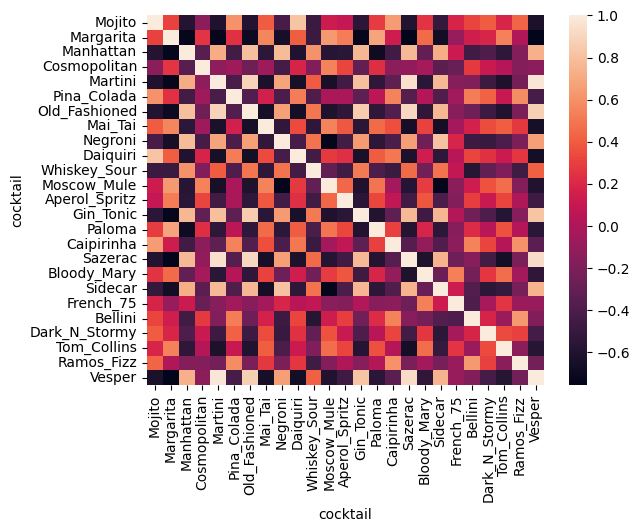

In [325]:
sns.heatmap(df_cocktail_sim_collab)

Earlier we saw that based on cocktail features, "a Margarita is incredibly similar to a Paloma, both of which are very dissimilar to a Negroni." Here, we can see that this is generally true when using this other measure of similarity, albeit to differing degrees.

To see the rankings on a patron-by-patron basis, I can use the same functions as above and compare notes between methodologies:

In [328]:
generate_ranked_recs('Uche', df_pxc, df_cocktail_sim).join(
    generate_ranked_recs('Uche', df_pxc, df_cocktail_sim_collab), 
    how='left', 
    lsuffix= '_content',
    rsuffix='_collab')

,rank_content,rank_collab
cocktail,,
Aperol_Spritz,1,7
Ramos_Fizz,2,2
Cosmopolitan,3,1
Daiquiri,4,9
Caipirinha,5,6
Dark_N_Stormy,6,4
Mojito,7,8
Bellini,8,3
Pina_Colada,9,5


Wow--Uche's recommendations are quite different depending on method! Both systems think Uche would like a Ramos Fizz or a Cosmopolitan, but they have very different assessments of whether he should try an Aperol Spritz. From here, we could theoretically average out the rankings to determine what to recommend for Uche, or we could evaluate the distinct methods over time to determine which has more predictive power.